In [ ]:
# Importamos las  librerías necesarias

import pandas as pd                       #Manipulación de datos
import numpy as np                        #Operaciones numéricas
from PIL import Image                     # Cargar imágenes
import matplotlib.pyplot as plt           # Visualizar imágenes
from sklearn.metrics import mean_squared_error  # Calcular el error cuadrático medio (MSE)
from math import log10                    # Cálculo de PSNR
from sklearn.utils import shuffle         # mezclar los datos
import os                                 # proporciona una forma de interactuar con el sistema operativo
from google.colab import drive            # Permite montar Google Drive en el entorno Colab

In [ ]:
# Conexión a google drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cargar y normalizar la imagen

image_path = '/content/drive/MyDrive/kodim21.png'  # La ruta a la imagen
img = Image.open(image_path)
img = np.array(img) / 255.0  # Normalización de los valores de píxeles a [0, 1]

original_shape = img.shape               # Guardar forma original (para reconstruir)
pixels = img.reshape(-1, 3)              # Convertir imagen a matriz (n_pixeles x 3 canales)

In [ ]:
# Definición de clase propia para el modelo GMM

class GMM:
    """
    Implementación personalizada de un Modelo de Mezcla Gaussiana (GMM).
    """

    def __init__(self, n_components, max_iters=20):
        self.K = n_components
        self.max_iters = max_iters

    def _initialize(self, X):
        """
        Inicialización de medias, covarianzas y pesos.
        """
        n_samples, n_features = X.shape
        self.means = X[np.random.choice(n_samples, self.K, replace=False)]  # Medias iniciales aleatorias
        self.covariances = np.array([np.cov(X.T) + 1e-6 * np.identity(n_features) for _ in range(self.K)])  # Matrices de covarianza
        self.weights = np.ones(self.K) / self.K  # Pesos iniciales iguales

    def _gaussian_pdf(self, X, mean, cov):
        """
        Cálculo de la densidad de probabilidad para una gaussiana multivariada.
        """
        n = X.shape[1]
        cov_inv = np.linalg.inv(cov)
        diff = X - mean
        exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)
        denom = np.sqrt(((2 * np.pi) ** n) * np.linalg.det(cov))
        return np.exp(exponent) / denom

    def _e_step(self, X):
        """
        Paso E: calcular responsabilidades.
        """
        N = X.shape[0]
        responsibilities = np.zeros((N, self.K))

        for k in range(self.K):
            responsibilities[:, k] = self.weights[k] * self._gaussian_pdf(X, self.means[k], self.covariances[k])

        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)
        return responsibilities

    def _m_step(self, X, responsibilities):
        """
        Paso M: actualizar pesos, medias y covarianzas.
        """
        N, D = X.shape
        Nk = np.sum(responsibilities, axis=0)
        self.weights = Nk / N
        self.means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
        self.covariances = []

        for k in range(self.K):
            diff = X - self.means[k]
            cov_k = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff
            cov_k /= Nk[k]
            cov_k += 1e-6 * np.identity(D)
            self.covariances.append(cov_k)

    def fit(self, X):
        """
        Entrenamiento completo del GMM.
        """
        self._initialize(X)
        for _ in range(self.max_iters):
            responsibilities = self._e_step(X)
            self._m_step(X, responsibilities)

    def predict_proba(self, X, batch_size=10000):
        """
        Predicción de probabilidades de pertenencia por lotes.
        """
        N = X.shape[0]
        responsibilities = []
        for i in range(0, N, batch_size):
            batch = X[i:i + batch_size]
            resp_batch = np.zeros((batch.shape[0], self.K))
            for k in range(self.K):
                resp_batch[:, k] = self.weights[k] * self._gaussian_pdf(batch, self.means[k], self.covariances[k])
            resp_batch /= np.sum(resp_batch, axis=1, keepdims=True)
            responsibilities.append(resp_batch)
        return np.vstack(responsibilities)

    def compress(self, X, batch_size=10000):
        """
        Asignar a cada píxel el color de su componente más probable.
        """
        compressed = []
        for i in range(0, X.shape[0], batch_size):
            batch = X[i:i + batch_size]
            responsibilities = self.predict_proba(batch, batch_size)
            labels = np.argmax(responsibilities, axis=1)
            compressed_batch = self.means[labels]
            compressed.append(compressed_batch)
        return np.vstack(compressed)

In [ ]:
# Función para calcular PSNR (calidad de compresión)

def psnr(original, compressed):
    mse = mean_squared_error(original, compressed)
    if mse == 0:
        return float('inf')
    return 20 * log10(1.0 / np.sqrt(mse))


➡️  Procesando K = 100


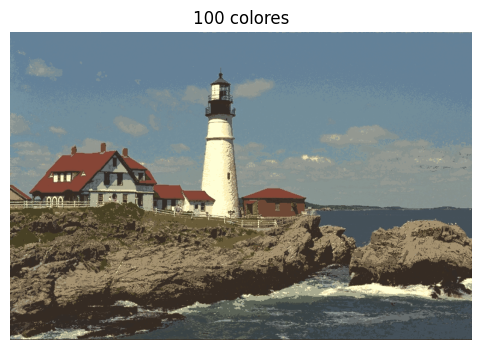

🔍 PSNR: 26.11 dB

➡️  Procesando K = 200


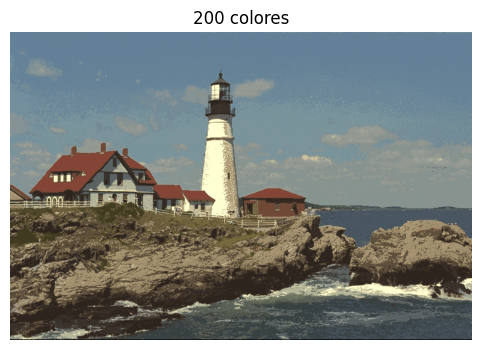

🔍 PSNR: 26.81 dB

➡️  Procesando K = 500


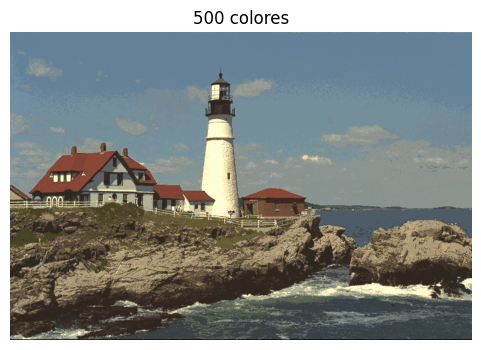

🔍 PSNR: 27.80 dB

➡️  Procesando K = 1000


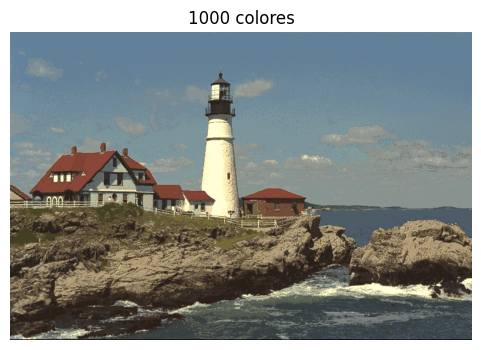

🔍 PSNR: 28.02 dB

➡️  Procesando K = 10000


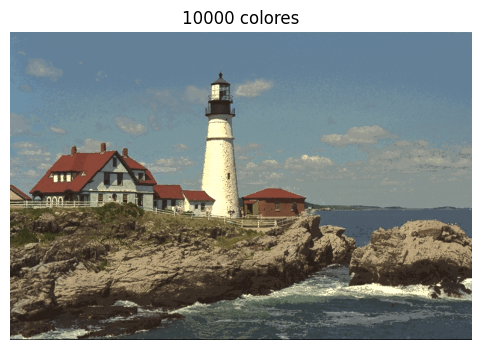

🔍 PSNR: 27.50 dB


In [ ]:
# Compresión con diferentes cantidades de colores

color_counts = [100, 200, 500, 1000, 10000]  # Cantidades de colores a probar

for K in color_counts:
    print(f"\n➡️  Procesando K = {K}")

    # Entrenamiento con una muestra de 10.000 píxeles para optimizar tiempos
    X_sample = shuffle(pixels, random_state=42)[:10000]
    gmm = GMM(n_components=K, max_iters=20)
    gmm.fit(X_sample)

    # Compresión de toda la imagen utilizando el modelo entrenado
    compressed_pixels = gmm.compress(pixels, batch_size=10000)
    compressed_img = compressed_pixels.reshape(original_shape)

    # Mostrar imagen comprimida
    plt.figure(figsize=(6, 4))
    plt.imshow(compressed_img)
    plt.title(f"{K} colores")
    plt.axis('off')
    plt.show()

    # Calcular PSNR para medir calidad de compresión
    score = psnr(pixels, compressed_pixels)
    print(f"🔍 PSNR: {score:.2f} dB")

Conclusion:

Es posible concluir que a valores bajos de K , se sacrifica demasiado la calidad visual en la compresión, resultando en imágenes pixeladas y con pérdida de detalles sutiles. A medida que K  aumenta, la calidad de la imagen comprimida mejora significativamente, acercándose más a la fidelidad de la imagen original.
Una menor numero de colores, asociado a bajos valores de K,  implica una mayor reducción del espacio ocupado pero al costo de una mayor degradación visual. Por lo tanto, para aplicaciones prácticas, es fundamental encontrar un equilibrio entre compresión y calidad visual, dependiendo del propósito específico de la imagen.
